In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

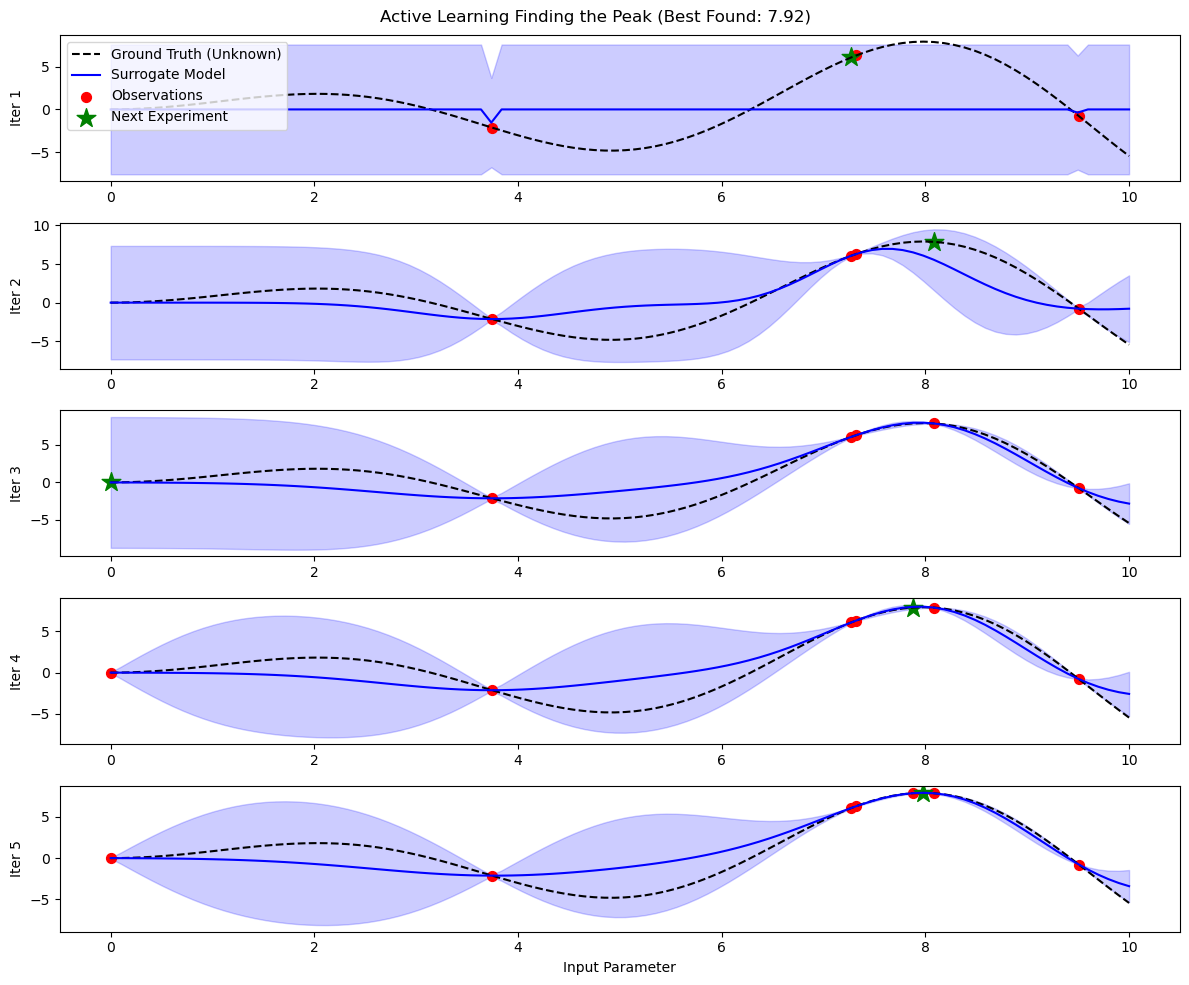

In [12]:
# --- 1D ACTIVE LEARNING EXAMPLE ---

# 1. The "Ground Truth"
# We want to find the peak of this function. The algo DOES NOT know this equation.
def ground_truth_1d(x):
    return x * np.sin(x)

# 2. The Acquisition Function (Upper Confidence Bound)
# High Mean = Exploitation, High Std = Exploration
def acquisition_function(X, model, alpha=1.96): # 95% Confidence Interval
    mean, std = model.predict(X, return_std=True)
    return mean + alpha * std

# --- SETUP ---
# The Search Space (0 to 10)
X_domain = np.linspace(0, 10, 100).reshape(-1, 1) # Column vector
y_true = ground_truth_1d(X_domain)

# Initial Data: 3 random points
rng = np.random.RandomState(42)
X_train = rng.uniform(0, 10, 3).reshape(-1, 1)
y_train = ground_truth_1d(X_train)

# The Model (Gaussian Process)
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2)) # Radial Basis Function Kernel (Enforces Smoothness)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.001)

# --- THE ACTIVE LEARNING LOOP ---
n_iterations = 5

plt.figure(figsize=(12, 10))

for i in range(n_iterations):
    # Step A: Fit the model to current data
    gp.fit(X_train, y_train)
    
    # Step B: Choose next point using Acquisition Function
    acq_values = acquisition_function(X_domain, gp)
    next_index = np.argmax(acq_values)
    next_x = X_domain[next_index].reshape(-1, 1)
    
    # Step C: "Run Experiment" (Query Ground Truth)
    next_y = ground_truth_1d(next_x)
    
    # Step D: Update Data
    X_train = np.vstack([X_train, next_x])
    y_train = np.vstack([y_train, next_y])
    
    # --- PLOTTING (Visualize the process) ---
    plt.subplot(n_iterations, 1, i+1)
    
    # Plot Ground Truth (Dashed)
    plt.plot(X_domain, y_true, 'k--', label='Ground Truth (Unknown)')
    
    # Plot Model Prediction (Blue Line) + Uncertainty (Shade)
    mean, std = gp.predict(X_domain, return_std=True)
    plt.plot(X_domain, mean, 'b-', label='Surrogate Model')
    plt.fill_between(X_domain.ravel(), mean - 1.96*std, mean + 1.96*std, alpha=0.2, color='blue')
    
    # Plot Known Data Points (Red Dots)
    plt.scatter(X_train[:-1], y_train[:-1], c='red', s=50, label='Observations')
    
    # Plot The Decision (Green Star)
    plt.scatter(next_x, next_y, c='green', marker='*', s=200, label='Next Experiment')
    
    plt.ylabel(f"Iter {i+1}")
    if i == 0: plt.legend(loc='upper left')

plt.xlabel("Input Parameter")
plt.suptitle(f"Active Learning Finding the Peak (Best Found: {np.max(y_train):.2f})")
plt.tight_layout()
plt.show()

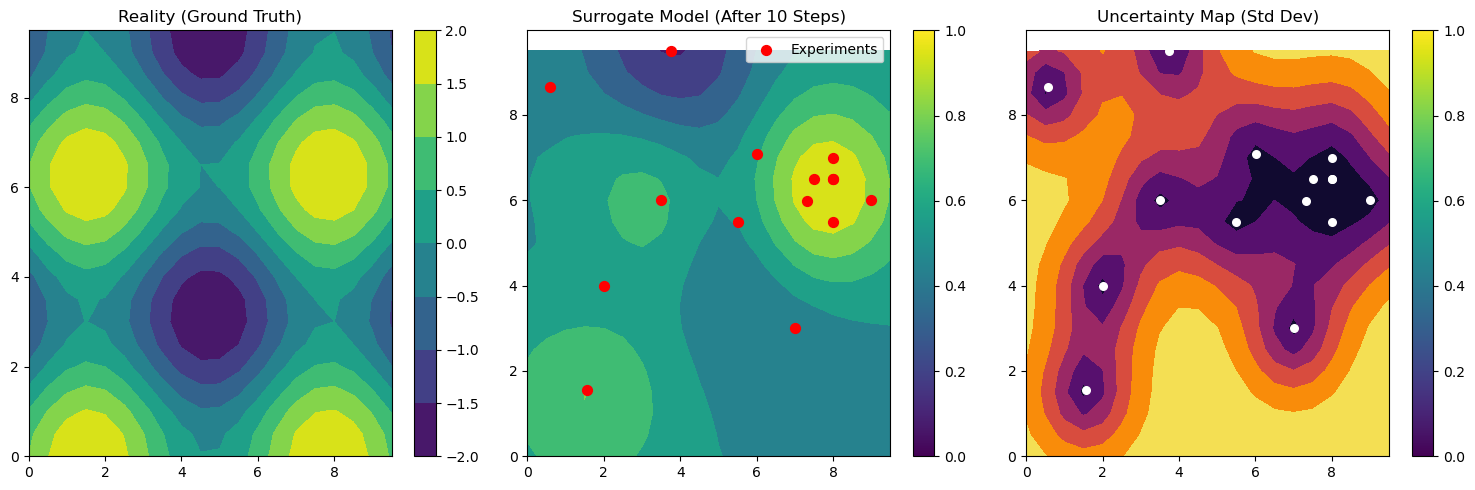

In [13]:
# --- 2D ACTIVE LEARNING EXAMPLE ---
# 1. The 2D Ground Truth
# A function with multiple hills and valleys.
def ground_truth_2d(X):
    # X is a matrix with 2 columns
    # Function: sin(x) + cos(y)
    return np.sin(X[:, 0]) + np.cos(X[:, 1])

# 2. The Acquisition Function (Same)
def acquisition_function(X, model, alpha=1.96):
    mean, std = model.predict(X, return_std=True)
    return mean + alpha * std

# --- SETUP THE GRID ---
# We create a 2D mesh (grid) to represent the search space
x_min, x_max = 0, 10
res = 0.5 # Resolution (step size)
x1_grid, x2_grid = np.meshgrid(np.arange(x_min, x_max, res),
                               np.arange(x_min, x_max, res))

# Flatten the grid into a list of [x, y] points for the model
# Shape becomes (N_points, 2)
X_domain = np.column_stack([x1_grid.ravel(), x2_grid.ravel()])

# Initial Data: 5 random points
rng = np.random.RandomState(42)
X_train = rng.uniform(x_min, x_max, (5, 2)) # Note: (5, 2) shape
y_train = ground_truth_2d(X_train)

# The Model (Standard GP)
kernel = C(1.0) * RBF([1.0, 1.0]) # RBF now has 2 dimensions
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.01)

# --- THE LOOP ---
n_iterations = 10

plt.figure(figsize=(15, 5))

for i in range(n_iterations):
    # A. Fit
    gp.fit(X_train, y_train)
    
    # B. Choose (Acquisition)
    acq_values = acquisition_function(X_domain, gp)
    next_index = np.argmax(acq_values)
    next_x = X_domain[next_index].reshape(1, -1)
    
    # C. Experiment
    next_y = ground_truth_2d(next_x)
    
    # D. Update
    X_train = np.vstack([X_train, next_x])
    y_train = np.hstack([y_train, next_y])

# --- VISUALIZATION ---

# 1. Plot the "Ground Truth" (Reality)
plt.subplot(1, 3, 1)
plt.title("Reality (Ground Truth)")
real_z = ground_truth_2d(X_domain).reshape(x1_grid.shape)
plt.contourf(x1_grid, x2_grid, real_z, cmap='viridis')
plt.colorbar()

# 2. Plot the "Model's Estimate" (Prediction)
plt.subplot(1, 3, 2)
plt.title(f"Surrogate Model (After {n_iterations} Steps)")
pred_mean, _ = gp.predict(X_domain, return_std=True)
pred_z = pred_mean.reshape(x1_grid.shape)
plt.contourf(x1_grid, x2_grid, pred_z, cmap='viridis')
plt.scatter(X_train[:, 0], X_train[:, 1], c='red', s=50, label='Experiments') # Show shots
plt.colorbar()
plt.legend()

# 3. Plot the "Uncertainty"
plt.subplot(1, 3, 3)
plt.title("Uncertainty Map (Std Dev)")
_, pred_std = gp.predict(X_domain, return_std=True)
std_z = pred_std.reshape(x1_grid.shape)
plt.contourf(x1_grid, x2_grid, std_z, cmap='inferno') # 'inferno' highlights heat
plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=30)
plt.colorbar()

plt.tight_layout()
plt.show()

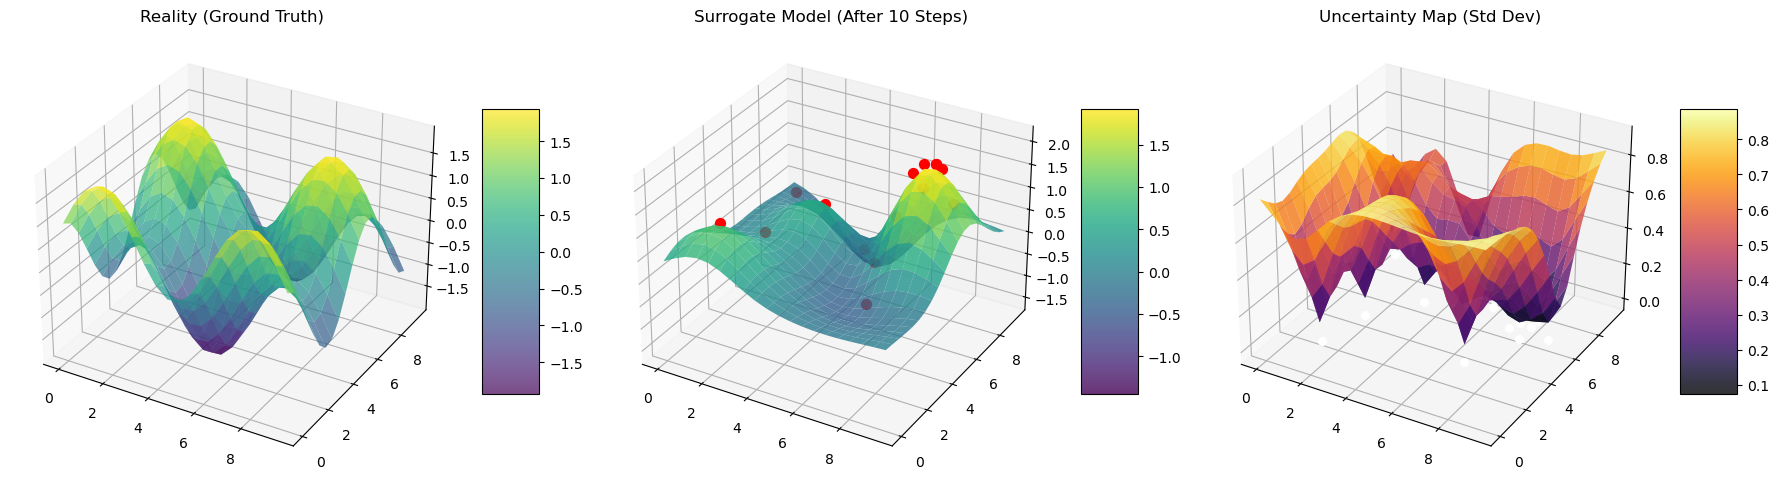

In [14]:
# --- 3D VISUALIZATION ---
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(18, 6))

# 1. Plot the "Ground Truth"
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.set_title("Reality (Ground Truth)")
real_z = ground_truth_2d(X_domain).reshape(x1_grid.shape)
surf1 = ax1.plot_surface(x1_grid, x2_grid, real_z, cmap='viridis', alpha=0.7)
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

# 2. Plot the "Model's Estimate" (Prediction)
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.set_title(f"Surrogate Model (After {n_iterations} Steps)")
pred_mean, _ = gp.predict(X_domain, return_std=True)
pred_z = pred_mean.reshape(x1_grid.shape)
surf2 = ax2.plot_surface(x1_grid, x2_grid, pred_z, cmap='viridis', alpha=0.8)
# Add red dots for the sampled points
# We need to calculate the Z-value (height) for the scatter points
scatter_z = ground_truth_2d(X_train) 
ax2.scatter(X_train[:, 0], X_train[:, 1], scatter_z + 0.1, c='red', s=50, label='Experiments', depthshade=False)
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

# 3. Plot the "Uncertainty"
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.set_title("Uncertainty Map (Std Dev)")
_, pred_std = gp.predict(X_domain, return_std=True)
std_z = pred_std.reshape(x1_grid.shape)
surf3 = ax3.plot_surface(x1_grid, x2_grid, std_z, cmap='inferno', alpha=0.8)
# Plot sampled points on the floor (uncertainty ~ 0 at these points)
ax3.scatter(X_train[:, 0], X_train[:, 1], np.zeros_like(scatter_z), c='white', s=30, depthshade=False)
fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()